In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/fa1_38_run_1'
data_files = '/mnt/tess/astronet/tfrecords-38-val/*'
tces_file = '/mnt/tess/astronet/tces-v14-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/fa1_38_run_1/1/AstroCNNModel_final_alpha_1_20220504_164445',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/2/AstroCNNModel_final_alpha_1_20220504_172032',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/3/AstroCNNModel_final_alpha_1_20220504_175419',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/4/AstroCNNModel_final_alpha_1_20220504_182735',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/5/AstroCNNModel_final_alpha_1_20220504_190055',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/6/AstroCNNModel_final_alpha_1_20220504_193432',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/7/AstroCNNModel_final_alpha_1_20220504_200824',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/8/AstroCNNModel_final_alpha_1_20220504_204203',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/9/AstroCNNModel_final_alpha_1_20220504_211537',
 '/mnt/tess/astronet/checkpoints/fa1_38_run_1/10/AstroCNNModel_final_alpha_1_20220504_214944']

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('astro_id'))
    print()

Running model 1
2491 records
Running model 2
2491 records
Running model 3
2491 records
Running model 4
2491 records
Running model 5
2491 records
Running model 6
2491 records
Running model 7
2491 records
Running model 8
2491 records
Running model 9
2491 records
Running model 10
2491 records


In [35]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.6

In [36]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for ex_id in preds.index:
        if ex_id not in agg_preds:
            agg_preds[ex_id] = []

        row = preds[preds.index == ex_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {ex_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[ex_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[ex_id].append(preds.columns[np.argmax(masked_v)])

In [37]:
final_preds = []
for ex_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[ex_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'astro_id': ex_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('astro_id')

In [38]:
tce_table = pd.read_csv(tces_file, header=0, low_memory=False)
tce_table['astro_id'] = tce_table['Astro ID']
tce_table = tce_table.set_index('astro_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels + ['TIC ID']]

pl = final_preds.join(tce_labels, on='astro_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [39]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9386973180076629
Precision: 0.8596491228070176


In [40]:
for i in pl[pos & pneg]['TIC ID']:
    print(i)

104485403
161687311
28484801
369264198
257485503
418100760
334227600
349412074
276978548
118412801
179637565
158159741
404220255
141753278
1715064237
188768068


In [9]:
for i in pl[neg & ppos]['TIC ID']:
    print(i)

252588526
164528404
192591652
198555242
431338538
278910035
91987762
237278147
277848886
154214348
279064110
136651206
269291226
468608862
97487520
405687343
233197293
127846210
298647682
138847344
284266496
56861756
395164445
267924099
648359612
188258751
101496204
122577745
241855882
335588842
842068824
356822358
275431073
18178958
165500081
408945155
219880693
356776209
278555119
27896467
375927073
14209654
417208086
135171752
154271808
1400086045
159636125
230197530
320356995
30407196
404851508
407615704
167039826
201601338
30275847
404851966
384341508
302968162
113496703
309650507
22892207
406971913
276738707
373919592
446698252
167809450
40602499
404851552
319865847
183978683
326693475
293527927
363404187
311103813
300153494
404733023
406091286
278413697
281578420
118398402
410087746
199376584


In [16]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == pl[pl['TIC ID'] == 118412801].index.values[0])

,disp_e,disp_n,disp_j,disp_s,disp_b
astro_id,,,,,
2919,0.000497,0.023041,0.996871,0.010173,0.001959
2919,0.005764,0.024955,0.948721,0.093139,0.002399
2919,0.001759,0.027560,0.980165,0.041605,0.002284
2919,0.000611,0.021570,0.997332,0.004780,0.001611
2919,0.003743,0.038888,0.990707,0.008697,0.002172
2919,0.000897,0.017680,0.995467,0.006299,0.001214
2919,0.012977,0.040268,0.914150,0.104075,0.007858
2919,0.003459,0.035027,0.980079,0.046869,0.003260
2919,0.004241,0.028279,0.980136,0.019056,0.003319


In [11]:
pl[pl.index == pl[pl['TIC ID'] == 1254504863].index.values[0]]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b,TIC ID
astro_id,,,,,,,,,,,,
26515,0,0,10,0,0,10,0,0,5,0,2,1254504863


### PR curve

In [12]:
ids = set(ensemble_preds[0].index.values)

index = {v: i for i, v in enumerate(ids)}

pred_es = np.zeros([len(ensemble_preds), len(index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        ex_id, pred_e = row[0], row[1][col_e]
        pred_es[i][index[ex_id]] = pred_e

lbl_es = np.zeros([len(index)], dtype=np.bool)
for row in tce_labels.iterrows():
    ex_id, lbl_e = row[0], row[1]['disp_e']
    lbl_es[index[ex_id]] = (lbl_e > 0)

In [13]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9670730933258337, max R: 1.0, max P: 1.0
100% recall at: 38%, threshold: 0.008498748302514292


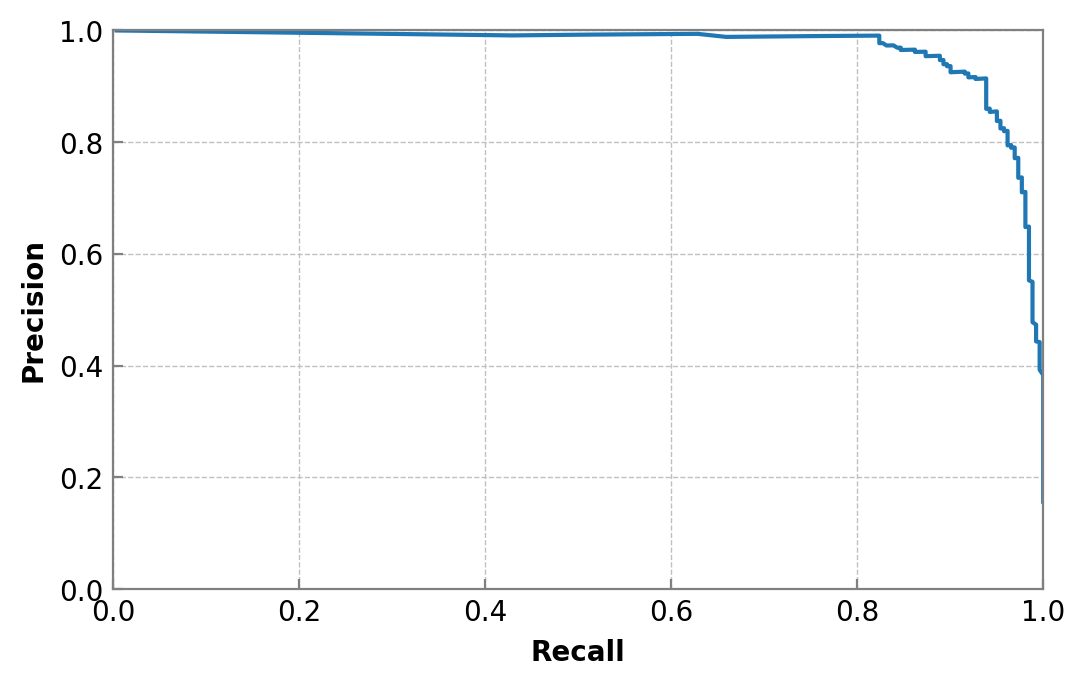

In [14]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)